In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

transactions_df = pd.read_csv('TASK3/Transactions.csv')
customers_df = pd.read_csv('TASK3/Customers.csv')

In [16]:
# Merge datasets
merged_df = transactions_df.merge(customers_df, on="CustomerID", how="left")

# Aggregate customer-level transaction data
customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total products purchased
    'Price': 'mean',      # Average price of purchased products
}).reset_index()


In [17]:
# Add customer profile features (e.g., Region)
customer_features = customer_features.merge(customers_df[['CustomerID', 'Region']], on="CustomerID", how="left")

# Encode categorical features (Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [18]:
# Standardize numeric features for clustering
scaler = StandardScaler()
numeric_columns = ['TotalValue', 'Quantity', 'Price']
customer_features[numeric_columns] = scaler.fit_transform(customer_features[numeric_columns])

# Prepare data for clustering
X = customer_features.drop('CustomerID', axis=1)

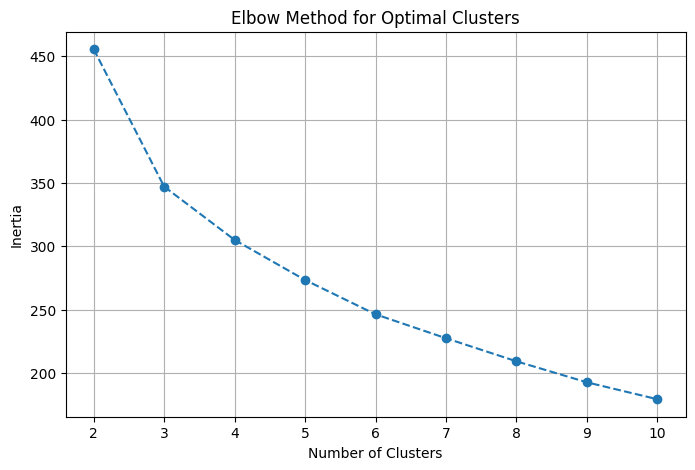

In [19]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

In [20]:
# Perform clustering with the optimal number of clusters (e.g., 4 clusters)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
customer_features['Cluster'] = clusters

# Calculate clustering metrics
db_index = davies_bouldin_score(X, clusters)

print(f"Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

Number of Clusters: 4
Davies-Bouldin Index: 1.3386


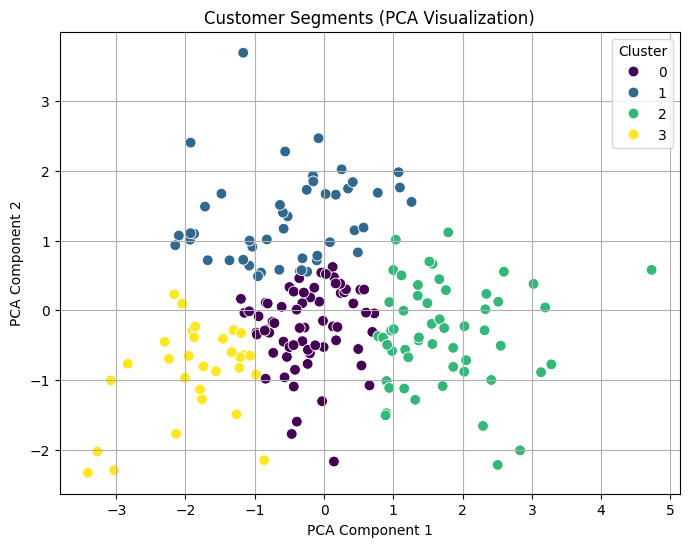

In [21]:
# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=60)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [22]:
# Save cluster assignments
customer_features[['CustomerID', 'Cluster']].to_csv("Customer_Segments.csv", index=False)

# -------------------
# Summary of Results:
# -------------------
print("Customer Segmentation Results:")
print(customer_features.groupby('Cluster').agg({
    'TotalValue': ['mean', 'sum'],
    'Quantity': ['mean', 'sum'],
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'}))

Customer Segmentation Results:
        TotalValue             Quantity            CustomerCount
              mean        sum      mean        sum         count
Cluster                                                         
0        -0.189091 -12.669124 -0.027162  -1.819847            67
1        -0.430286 -20.223425 -0.819048 -38.495257            47
2         1.260576  69.331665  1.249993  68.749604            55
3        -1.214637 -36.439116 -0.947817 -28.434500            30
